In [ ]:
!pip install netCDF4
from google.colab import drive
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 34.2 MB/s eta 0:00:00
Mounted at /content/drive


In [ ]:

# I did not write this code chat gpt helped me learn this data file type
import os
import numpy as np
from netCDF4 import Dataset
#'/content/drive/MyDrive/ERSST v5 LSTM/New Data ?'

def dataloader(a):
  directory_path = a

  nc_files = [f for f in os.listdir(directory_path) if f.endswith('.nc')]

  # Initialize empty lists to store data
  sst_data_list = []
  lat_data = None
  lon_data = None

  # Loop through each .nc file and read its data
  for nc_file in nc_files:
      file_path = os.path.join(directory_path, nc_file)

      # Open the NetCDF file
      dataset = Dataset(file_path, 'r')

      # Extract the variables (make sure all files have the same structure)
      sst = dataset.variables['sst'][:]  # Assuming 'sst' is the variable name for sea surface temperature
      lat = dataset.variables['lat'][:]
      lon = dataset.variables['lon'][:]

      # Store latitude and longitude data (assuming they are the same across all files)
      if lat_data is None:
          lat_data = lat
      if lon_data is None:
          lon_data = lon

      # Append the SST data (assuming the data is ordered by time)
      sst_data_list.append(sst)

      # Close the dataset after processing
      dataset.close()

# I did write this code
  sst_combined = np.concatenate(sst_data_list, axis=0)
  sst_combined = np.squeeze(sst_combined)
  print(f"Combined SST shape: {sst_combined.shape}")
  return sst_combined

climatology = dataloader('/content/drive/MyDrive/ERSST v5 LSTM/New Data ?')
print(1)
sst_combined = dataloader('/content/drive/MyDrive/ERSST v5 LSTM/ERSST v5 2014-2024')
print(2)



Combined SST shape: (12, 89, 180)
1
Combined SST shape: (139, 89, 180)
2


In [ ]:
'''
resshape the data such that every column corresponds to one grid location. I wrote this code
'''
climatology_cut = climatology[:, 42:48, 60:85]
climatology_cut = np.nan_to_num(climatology_cut, nan=0)
print(climatology_cut.shape)
sst_combined_cut = sst_combined[:, 42:48, 60:85]
sst_combined_cut = arr = np.nan_to_num(sst_combined_cut, nan=0)
print(sst_combined_cut.shape)



(12, 6, 25)
(139, 6, 25)


This Model will be a generative model. Via the LSTM framework I will construct a mode that examens the ERSST v5 data and constructs a prediction that fits within the ONI framework

 **'The Oceanic Niño Index (ONI) is one of the most widely used metrics to measure the strength of El Niño and La Niña events. It is based on the SST anomalies in the Niño 3.4 region (5°N-5°S, 120°W-170°W). The ONI is calculated as a 3-month running mean of the SST anomalies, which are compared to a long-term average. El Niño is typically declared when the ONI is greater than +0.5°C for at least five consecutive overlapping 3-month periods.'**


The loss will be calculated by **mean squared error** based on difference from the known ONI values. The idea here is to penalize large outlying values(ofcourse this is subject to change based on the perfomrance of the model).


In [ ]:
'''
Generate the SST anomaly from the ERSST data

value - climatalogical mean

sst anomaly > 0.5 el nino conditions
sst anomaly < -0.5 la nino conditions
0.5 > sst anomaly > -0.5 neutral conditions

'''
'''
 month = k % 11
      sst_anomaly[k][j][i] = sst_combined_cut[k][j][i] - climatology_cut[month][j][i]


'''

#I wrote all of this code

month = 0
sst_climatology = np.zeros((6, 25))
for i in range(sst_combined_cut.shape[1]):
  for j in range(sst_combined_cut.shape[2]):
    sst_climatology[i, j] = np.mean(sst_combined_cut[:, i, j])
print(sst_climatology.shape)

sst_anomaly = sst_combined_cut
month = 0

for i in range(sst_combined_cut.shape[2]):
  for j in range(sst_combined_cut.shape[1]):
    for k in range(sst_combined_cut.shape[0]):
      sst_anomaly[k, j ,i] = sst_combined_cut[k, j, i] - sst_climatology[j, i]
print(sst_anomaly.shape)

#print(sst_anomaly[:,4,9])
'''
for i in range(sst_combined_cut.shape[2]):
  for j in range(sst_combined_cut.shape[1]):
    for k in range(sst_combined_cut.shape[0]):
      sst_anomaly[k, j ,i] = sst_combined_cut[k, j, i] - sst_climatology[j, i]
print(sst_anomaly.shape)
'''


(6, 25)
(139, 6, 25)


'\nfor i in range(sst_combined_cut.shape[2]):\n  for j in range(sst_combined_cut.shape[1]):\n    for k in range(sst_combined_cut.shape[0]):\n      sst_anomaly[k, j ,i] = sst_combined_cut[k, j, i] - sst_climatology[j, i]\nprint(sst_anomaly.shape)\n'

data shape
(1524, 12, 3, 3)
label shape
(1524,)
1524
X_test torch.Size([305, 12, 9])
Y_test torch.Size([305])
X_train torch.Size([1219, 12, 9])
Y_train torch.Size([1219])


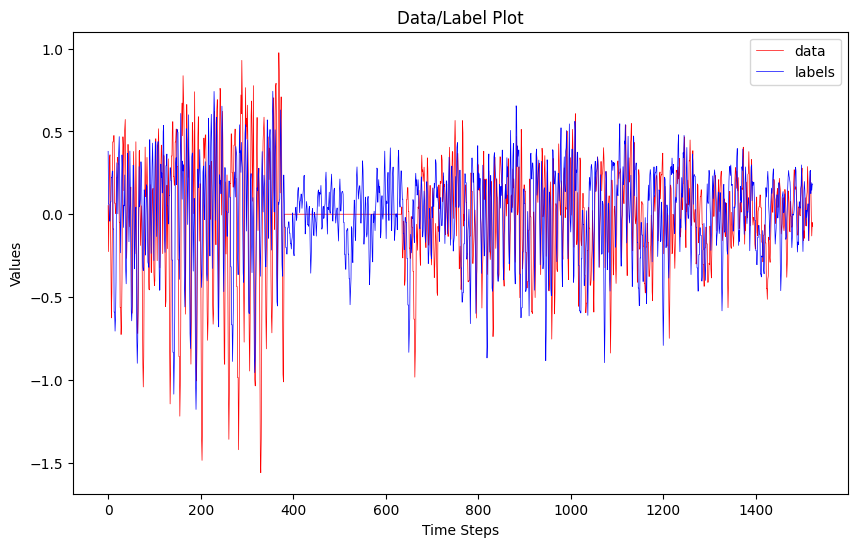

In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

max = np.max(sst_combined_cut)
data = sst_combined_cut/max

'''
split data into 3X3 boxes

1. This is based on the assumption that data near other data is probably related given assumptions of smoothness and continuity
2. This is also based on the effort to see if ENSO behaviour can be predicted at all effectively with time series information alone i.e. removing the potential teloconnection aspect of training based on the timeseries information from the entire globe
3. This will provide a greate deal more training data
'''

# I wrote all of this code
def chunker(data):
  cofactors = []
  for i in range(2):
    for j in range(6):
        topi = ((i+1)*3)
        bottomi = i*3
        topj = ((j+1)*3)
        bottomj = j*3
        cofactors.append(data[:,bottomi:topi,bottomj:topj])
  return cofactors

def split_data(data, label):
    data_list = []

    # create all possible sequences of length seq_len
    for i in range(139 - 12):
      if label == 0:
        data_list.append(data[i:i+12,:,:])
      if label == 1:
        if i < 139-13:
          data_list.append(np.average(data[i+13,:,:]))
        else:
          data_list.append(np.average(data[i+12,:,:]))
    '''
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);

    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]

    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    '''

    data_list = np.array(data_list)

    return data_list

data = chunker(data)

combos = []
combo_labels = []
for i in range(12):
  combos.append(split_data(data[i], 0))
  combo_labels.append(split_data(data[i], 1))
data = np.stack(combos, axis = 0)
label = np.stack(combo_labels, axis = 0)

for i in range(12):
  if(i == 0):
    array = data[i,:,:,:]
    array_label = label[i,:]
  else:
    array = np.concatenate((array, data[i,:,:,:]), axis = 0)
    array_label = np.concatenate((array_label,(label[i,:])), axis = 0)
data = array
label_combo = array_label
print('data shape')
print(data.shape)
print('label shape')
print(array_label.shape)
data = data.reshape(1524, 12, -1)



'''
labels = chunker(sst_anomaly)
label_combo = []
for i in range(12):
  label_combo.append(split_data(labels[i], 1))
label_combo = np.concatenate(label_combo, axis = 0)
print(label_combo.shape)
'''

'''
labels = []
for i in range(1524):
  labels.append(np.mean(data[i,0,:], axis = 0))
labels = np.stack(labels, axis = 0)

label_combo = np.array(labels)
data = np.array(data);
'''
plt.figure(figsize=(10, 6))
plt.plot(data[:,0,0], label='data', color='red', linestyle='-', linewidth=0.5)
plt.plot(label_combo, label='labels', color='blue', linestyle='-', linewidth=0.5)
plt.title('Data/Label Plot')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.legend()

'''
interpolate to simulate more detailed data make the assumption that the space between points will continue either quadratically or linearly
*note implicit assumption of smooth and c.t.s behaviour
'''

def interpolator(data, coarseness):
  newdata = []
  for i in range(data.shape[0]):
    #print(i)
    newtime = np.linspace(0, 1, (((data.shape[1]-2)*coarseness) + 2)*9)
    newtime = newtime.reshape((((data.shape[1]-2)*coarseness) + 2), 9)
    for k in range(data.shape[1]):
      if k == (data.shape[1]-1):
        newtime[k + coarseness] = data[i,k,:]
      else:
        point = data[i,k+1,:] - data[i,k,:]
        slope = point/coarseness
        for x in range(coarseness):
          newtime[k+x, :] = point + x*slope
    newdata.append(newtime)
  data = np.stack(newdata, axis=0)
  print('length')
  print(len(newdata))
  return data

#data = interpolator(data, 10)


'''
randomize to fix wierd split
'''
np.random.seed(0)
np.random.shuffle(data)
np.random.seed(0)
np.random.shuffle(label_combo)
print
test_size = int(np.round(0.2*data.shape[0]));
train_size = data.shape[0] - (test_size);

x_train = data[:train_size,:,:]
y_train = label_combo[:train_size]
print((test_size+train_size))
x_test = data[train_size:,:,:]
y_test = label_combo[train_size:]


x_train = torch.tensor(x_train)
x_train = x_train.float()
y_train = torch.tensor(y_train)
y_train = y_train.float()
x_test = torch.tensor(x_test)
x_test = x_test.float()
y_test = torch.tensor(y_test)
y_test = y_test.float()

print('X_test', x_test.shape)
print('Y_test', y_test.shape)
print('X_train', x_train.shape)
print('Y_train', y_train.shape)

labels = torch.tensor(label_combo)







**Objectives:**
\- 1. Figure Finalize Data Set done
\- 2. Build neural network
\- 3. Figure out predicting value doneish
\- 4. Structure experiment
\- 5. Train
\- 6. Present Results

In [ ]:
'''
LSTM model structure before modification taken from: https://medium.com/swlh/stock-price-prediction-with-pytorch-37f52ae84632
I did not originally write this code but I added small bits a pieces
'''
input_dim = 9
output_dim = 1
hidden_dim = 6
num_layers = 1
output_dim = 1
num_epochs = 6
length_epoch = 15
batchsize = 12
learning_rate = 0.00001

class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, dropout = 0.3, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim)
        out, (hn, cn) = self.lstm(x, (h0, c0))
        #out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

def custom_loss(predictions, targets):
  mse_loss = nn.MSELoss()(predictions, targets)
  reward_factor = torch.abs(predictions).mean()

  return mse_loss - reward_factor

model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
#criterion = custom_loss
#criterion = nn.L1Loss()
criterion = nn.MSELoss(reduction = 'mean')
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)





/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


In [ ]:
'''
Train the model

I took this code from the medium example and then heavily adapted it to my purposes adding loops
and a test set evaluation to give a better picture of model performance and to give my self more
control of how much data and with what parameters the model has access to
'''

import time
import itertools
from itertools import product
import math
import random

def trainer (num_epochs, batchsize, length_epoch,  x_train, y_train, x_test, y_test):
  hist = np.zeros(num_epochs)
  start_time = time.time()
  lstm = []
  x_trains = torch.split(x_train, batchsize, dim = 0)
  y_trains = torch.split(y_train, batchsize, dim = 0)
  final_loss = 0
  for t in range(num_epochs):
    if (t != 0):
      y_test_pred = model(x_test)
      loss = criterion(y_test_pred, y_test)
      #print("Test Loss ", "MSE: ", loss.item())
      for k in range(len(x_trains)):
        x_model = x_trains[k]
        y_model = y_trains[k]
        y_train_pred = model(x_model)
        loss = criterion(y_train_pred, y_model)
        print("Epoch ", t, "MSE: ", loss.item())
        hist[t] = loss.item()

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        final_loss = loss


  training_time = time.time()-start_time
  #print("Training time: {}".format(training_time))
  return (final_loss, model)

learning_rates = np.linspace(1e-6, 1e-1, num=5)
batch_size = [12, 18, 24, 36, 50]
num_epochs = np.linspace(1, 25, num = 6)
hidden_dim = np.linspace(1, 8, num = 4)
epoch_length = np.linspace(1, 15, num = 5)
layers = np.linspace(1, 5, num = 5)
param_grid = list(product(learning_rates, batch_size, num_epochs, hidden_dim, layers))

results = []
'''
for i in range(20):
  params = random.choice(param_grid)
  model = LSTM(input_dim=input_dim, hidden_dim=math.floor(params[3]), output_dim=output_dim, num_layers=math.floor(params[4]))
  optimiser = torch.optim.Adam(model.parameters(), lr=params[0])
  results.append(trainer(math.floor(params[2]), math.floor(params[1]), math.floor(params[1]), x_train, y_train, x_test, y_test))

best_model = min(results, key=lambda x: x[0])
best_model = best_model[1]
y_test_pred = best_model(x_test)
loss = criterion(y_test_pred, y_test)
print("Final Test Loss ", "MSE: ", loss.item())
'''

model = LSTM(input_dim=input_dim, hidden_dim= 2, output_dim=output_dim, num_layers=1)
optimiser = torch.optim.Adam(model.parameters(), lr=0.00001)
trainer(6,12,12, x_train, y_train, x_test, y_test)


Epoch  1 MSE:  0.08195686340332031
Epoch  1 MSE:  0.11073818802833557
Epoch  1 MSE:  0.13212773203849792
Epoch  1 MSE:  0.0977984368801117
Epoch  1 MSE:  0.12420965731143951
Epoch  1 MSE:  0.10998909175395966
Epoch  1 MSE:  0.08194143325090408
Epoch  1 MSE:  0.15929342806339264
Epoch  1 MSE:  0.10334660857915878
Epoch  1 MSE:  0.05097100883722305
Epoch  1 MSE:  0.1919524073600769
Epoch  1 MSE:  0.04332045093178749
Epoch  1 MSE:  0.14289376139640808
Epoch  1 MSE:  0.2265540212392807
Epoch  1 MSE:  0.10753792524337769
Epoch  1 MSE:  0.08743484318256378
Epoch  1 MSE:  0.21548661589622498
Epoch  1 MSE:  0.21203379333019257
Epoch  1 MSE:  0.029733624309301376
Epoch  1 MSE:  0.17975598573684692
Epoch  1 MSE:  0.08032317459583282
Epoch  1 MSE:  0.09405307471752167
Epoch  1 MSE:  0.16023646295070648
Epoch  1 MSE:  0.18563759326934814
Epoch  1 MSE:  0.22396506369113922
Epoch  1 MSE:  0.2348358929157257
Epoch  1 MSE:  0.06699841469526291
Epoch  1 MSE:  0.21271297335624695
Epoch  1 MSE:  0.075951

(tensor(0.2080, grad_fn=<MseLossBackward0>),
 LSTM(
   (lstm): LSTM(9, 2, batch_first=True, dropout=0.3)
   (fc): Linear(in_features=2, out_features=1, bias=True)
 ))

In [1]:
import matplotlib.pyplot as plt

'''
I wrote all of this code
'''
'''
plt.figure(figsize=(10, 6))
plt.plot(hist, label='Training Loss', color='blue')
plt.title('Training Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
'''

y_test_pred = model(x_test)

print(1)
print(1)
print(criterion(y_test_pred.detach(), y_test.detach()))
plt.figure(figsize=(10, 6))
plt.plot(y_test.detach(), label='True Values', color='blue', linestyle='-', linewidth=2)
plt.plot(y_test_pred.detach(), label='Predictions', color='red', linestyle='--', linewidth=2)
plt.title('Predictions vs True Values')
plt.xlabel('Time Steps')
plt.ylabel('SST Anomaly C')
plt.legend()

y_pred = model(x_train)
plt.figure(figsize=(10, 6))
plt.plot(y_train.detach(), label='True Values', color='blue', linestyle='-', linewidth=2)
plt.plot(y_pred.detach(), label='Predictions', color='red', linestyle='--', linewidth=2)
plt.title('Predictions vs True Values')
plt.xlabel('Time Steps')
plt.ylabel('SST Anomaly C')
plt.legend()

plt.figure(figsize=(10, 6))
plt.plot(y_test_pred.detach(), label='Test Pred', color='blue', linestyle='-', linewidth=0.5)
plt.plot(y_pred.detach(), label='Train Pred', color='red', linestyle='--', linewidth=0.5)
plt.title('Predictions vs True Values')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.legend()

'''
for shits and giggles
'''

'''
plt.figure(figsize=(10, 6))
plt.plot(y_test.detach(), label='True test', color='blue', linestyle='-', linewidth=2)
plt.plot(y_train.detach(), label='True train', color='red', linestyle='--', linewidth=2)
plt.title('Predictions vs True Values')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.legend()

plt.figure(figsize=(10, 6))
plt.plot(y_test.detach(), label='True Values', color='blue', linestyle='-', linewidth=2)
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.legend()
'''





NameError: name 'model' is not defined